In [1]:
# imports
import pylab as pl
import numpy as np
import wave
from sklearn import decomposition
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import FastICA
from time import time
from numpy.random import RandomState
import pylab as pl
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn import decomposition
from time import time
from sklearn.feature_extraction import text
from sklearn import decomposition
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Séparation de sources audio par ICA

1. Étudier le script ica_audio.py et l’utiliser pour générer le mélange stéréo. Prendre le
temps d’écouter les différents signaux.

In [2]:
def wavread(filename):
    wf = wave.open(filename)
    s = np.fromstring(wf.readframes(wf.getnframes()), dtype=np.int16)
    wf.close()
    return s
    
def wavwrite(filename, s, nchannels=1):
    wf = wave.open(filename,'wb')
    wf.setnchannels(nchannels)
    wf.setsampwidth(2)
    wf.setframerate(32000)
    s = s/max(abs(s))*2**14
    wf.writeframes(s.astype(np.int16).tostring())
    wf.close()

# read audio data
s1 = wavread('es02.wav')
s2 = wavread('si01.wav')
    
# create stereo mix
nsmp = min(len(s1), len(s2))
s1 = s1[:nsmp]
s2 = s2[:nsmp]
S = np.c_[s1, s2]  
A = np.array([[0.6, 0.5], [0.4, 0.5]])
X = S.dot(A)

# Write mix file
x = np.zeros(2*nsmp)
x[::2] = X[:,0]
x[1::2] = X[:,1]
wavwrite('mix.wav', x, nchannels=2)

2. Utiliser l’ICA pour extraire les sources originales à partir du mélange. On exploitera pour
cela sklearn.decomposition.FastICA.

Note: l'ICA ne peut pas extraire plus de composantes qu'elle n'en trouve dans les données. Donc si on veut extraire deux signaux audio séparés, il faut que la matrice d'input contienne au moins deux colonnes. Comme le mix audio généré x ne contient qu'une colonne, ça ne marchera pas! Il faut donc utiliser la matrice originale X, et non le mix une seule piste x!

In [3]:
# on déclare une instance de classe FastICA
transformer = FastICA(n_components=2)
X_transformed = transformer.fit_transform(X)

3. Créer les fichiers audio pour chaque source extraite et les écouter.

In [4]:
# on écrit les deux pistes obtenues
wavwrite('piste1.wav', X_transformed[:,0], nchannels=1)
wavwrite('piste2.wav', X_transformed[:,1], nchannels=1)

# Extraction de caractéristiques de visages

On étudie ici l’utilisation des techniques de décomposition par PCA et NMF pour l’extraction
de caractéristiques utiles à la reconnaissance automatique de visages.

1. Étudier et tester le script pca_nmf_faces.py. Analyser le type de décomposition obtenu
par NMF en comparaison avec celui obtenu par PCA.

In [5]:
# prepare data and define utility functions
n_row, n_col = 2, 5
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

In [6]:
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data
n_samples, n_features = faces.shape
faces_centered = faces - faces.mean(axis=0, dtype=np.float64)
print("Dataset consists of " + str(n_samples) + " faces.")

Dataset consists of 400 faces.


2061 negative-valued pixels
2773 negative-valued pixels
2630 negative-valued pixels
1422 negative-valued pixels
1242 negative-valued pixels
1004 negative-valued pixels
2049 negative-valued pixels
1580 negative-valued pixels
1387 negative-valued pixels
3819 negative-valued pixels
Extracting the top 10 Eigenfaces - PCA
done in 0.08795571327209473
3998 negative-valued pixels
2078 negative-valued pixels
1967 negative-valued pixels
1862 negative-valued pixels
2261 negative-valued pixels
1924 negative-valued pixels
1951 negative-valued pixels
1884 negative-valued pixels
2221 negative-valued pixels
1965 negative-valued pixels
Extracting the top 10 Non-negative components - NMF
done in 15.740316390991211


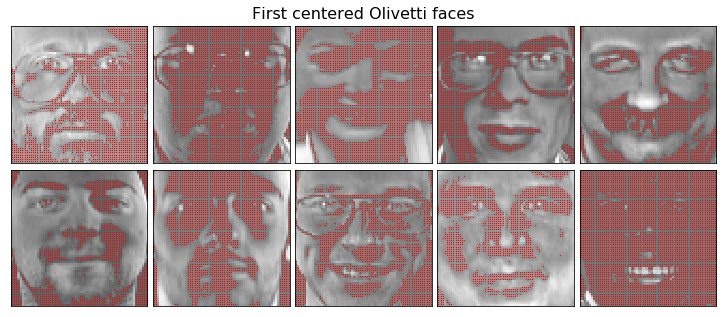

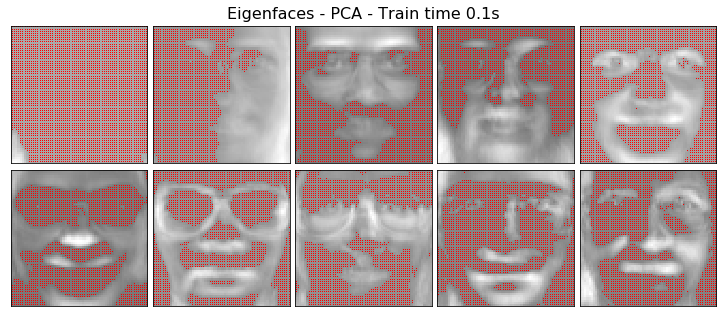

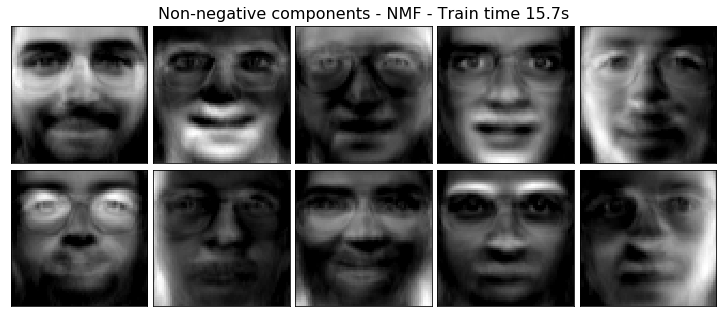

In [7]:
# function to plot gallery
def plot_gallery(title, images):
    pl.figure(figsize=(2. * n_col, 2.26 * n_row))
    pl.suptitle(title, size=16)
    for i, comp in enumerate(images):
        pl.subplot(n_row, n_col, i + 1)
        comp = comp.reshape(image_shape)
        vmax = comp.max()
        vmin = comp.min()
        dmy = np.nonzero(comp<0)
        if len(dmy[0])>0:
            yz, xz = dmy
        comp[comp<0] = 0
        
        pl.imshow(comp, cmap=pl.cm.gray, vmax=vmax, vmin=vmin)
        
        if len(dmy[0])>0:
            pl.plot( xz, yz, 'r,')  # , hold=True
            print(len(dmy[0]), "negative-valued pixels")
            
        pl.xticks(())
        pl.yticks(())
        
    pl.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
 
        
# Plot a sample of the input data
plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# -- Decomposition methods -----------------------------------------------------

# List of the different estimators and whether to center the data
estimators = [
    ('pca', 'Eigenfaces - PCA',
decomposition.PCA(n_components=n_components, whiten=True),
True),
('nmf', 'Non-negative components - NMF',
decomposition.NMF(n_components=n_components, init='random', tol=1e-6,
max_iter=2000),
False)
]

# -- Transform and classify ----------------------------------------------------
labels = dataset.target
X = faces
X_ = faces_centered

for shortname, name, estimator, center in estimators:
    #if shortname != 'nmf': continue
    print("Extracting the top " + str(n_components) + " " + name)
    t0 = time()
    
    data = X
    if center:
        data = X_
        
    data = estimator.fit_transform(data)
    
    train_time = (time() - t0)
    print("done in " + str(train_time))
    
    components_ = estimator.components_
    
    plot_gallery('%s - Train time %.1fs' % (name, train_time), components_[:n_components])


La PCA obtient des pixels négatifs (en rouge), contrairement à la NMF qui par construction ne conserve que des valeurs positives. La NMF rend donc des résultats plus satisfaisants en term de décomposition d'images.

2. Modifier le script pour réaliser une évaluation des performances d’un système de reconnaissance
automatique de visages utilisant les caractéristiques extraites par PCA, comparées
à celles obtenues par un système exploitant les caractéristiques extraites par NMF.
On pourra utiliser la LDA pour la classification. On effectuera l’évaluation par validation
croisée. On observera l’évolution des scores en faisant varier le nombre de composantes
utilisé dans les décompositions.

La question n'est pas très claire. Ce qu'il faudrait faire (je pense):

1) séparer l'échantillon en train et test.

2) estimer PCA d'un côté et NMF de l'autre, sur l'échantillon train.

3) pour chacune des méthodes, réduire la dimension des données train.

3) estimer une LDA sur les données réduites (pour chaque méthode), ce qui donne ensuite un classifieur.

4) pour chaque entrée de l'échantillon test, prendre les composantes principales, puis classifier par la LDA.

5) comparer les performances respectives obtenues par les deux méthodologies.

In [8]:
# on fixe le nombre de composantes principales
n_components = 1

In [9]:
# 1)
Xtrain, Xtest, X_train, X_test, y_train, y_test = train_test_split(X, X_, labels, test_size=0.2, random_state=42)

In [10]:
# 2)
# on estime d'abord la PCA
estimator_pca = decomposition.PCA(n_components=n_components, whiten=True)
data_pca = estimator_pca.fit_transform(X_train)
components_pca = estimator_pca.components_
# plot_gallery('%s - %.1i' % ('ACP', 1), components_pca[:n_components]) % use only if n_components = 10

In [11]:
# on estime ensuite la NMF
estimator_nmf = decomposition.NMF(n_components=n_components, init='random', tol=1e-6, max_iter=2000)
data_nmf = estimator_nmf.fit_transform(Xtrain)
components_nmf = estimator_nmf.components_
# plot_gallery('%s - %.i' % ('NMF', 2), components_nmf[:n_components]) % use only if n_components = 10

In [12]:
# 3)
lda_pca = LDA()
lda_pca.fit(data_pca, y_train);
lda_nmf = LDA()
lda_nmf.fit(data_nmf, y_train);

In [13]:
# 4)
# on obtient la réduction par acp sur l'échantillon test, puis on prédit avec lda
data_pca_test = estimator_pca.fit_transform(X_test)
pred_pca_test = lda_pca.predict(data_pca_test)
# on obtient la réduction par nmf sur l'échantillon test, puis on prédit avec lda
data_nmf_test = estimator_nmf.fit_transform(Xtest)
pred_nmf_test = lda_nmf.predict(data_nmf_test)

In [16]:
# 5)
score_pca = lda_pca.score(data_pca_test, y_test)
print("the score with pca is " + str(round(score_pca,3)) + ".")
score_nmf = lda_nmf.score(data_nmf_test, y_test)
print("the score with nmf is " + str(round(score_nmf,3)) + ".")

the score with pca is 0.0.
the score with nmf is 0.075.


Dans les deux cas les scores sont minables. J'ai essayé de jouer sur le nombre de composantes, et il semble que les meilleurs scores soient obtenus avec le nombre minimum (n_components = 1), ce qui n'a pas grand sens, sauf à considérer que les composantes suivantes sont uniquement du bruit qui détériore la prédiction. On note toutefois que quelle que soit le nombre de composantes, la nmf marche mieux que l'acp. 

Vu les résultats médiocres, il est vraisemblable que j'ai mal compris quelque chose, et que je n'applique pas la méthodologie comme il faut.

# Extraction de thèmes à partir de textes

Il s’agit dans cette partie de tester l’utilisation de laNMFpour l’extraction de thèmes à partir
d’un corpus de textes ; l’idée principale étant d’interpréter chaque composante NMF extraite
comme étant associée à un thème.

In [ ]:
n_samples = 1000
n_features = 1000
n_topics = 10
n_top_words = 20

# Load the 20 newsgroups dataset and vectorize it using the most common word
# frequency with TF-IDF weighting (without top 5% stop words)
t0 = time()
print("Loading dataset and extracting TF-IDF features...")
dataset = datasets.fetch_20newsgroups(shuffle=True, random_state=1)

vectorizer = text.CountVectorizer(max_df=0.95, max_features=n_features)
counts = vectorizer.fit_transform(dataset.data[:n_samples])
tfidf = text.TfidfTransformer().fit_transform(counts)
print("done in " + str((time() - t0)))

# Fit the NMF model
print("Fitting the NMF model on with " + str(n_samples) + " and " + str(n_features))
nmf = decomposition.NMF(n_components=n_topics).fit(tfidf)
print("done in " + str(time() - t0))

# Inverse the vectorizer vocabulary to be able
feature_names = vectorizer.get_feature_names()

for topic_idx, topic in enumerate(nmf.components_):
    print("Topic " + str(topic_idx))
    for i in topic.argsort()[:-n_top_words - 1:-1]:
        print (" ".join([feature_names[i]]))
    


Globalement, les topics sont assez peu satisfaisants. Ils ne parviennent pas vraiment à dégager de thématiques claires. On y retrouve beaucoup de pronoms et d'adverbes qui n'ont pas vraiment d'interpretabilité thématique.